# **AG_NEWS DATASET**

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. 

The 4 classes are World, Sports , Business ,Sci_Tech

Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

**Link for dataset**

Train Dataset = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"

Test Dataset = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv"

The files train.csv and test.csv contain all the training samples as comma-sparated values. 

There are 3 columns in them, corresponding to class index (1 to 4), title and description. 

The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). 

New lines are escaped by a backslash followed with an "n" character, that is "\n".


**The following code are preproceesing step for the AGNEWS DATASET**



## **0. Install Dependencies**

In [1]:
!pip install contractions
!pip install tqdm

## **1. Load the dependencies**

In [2]:
#Import our code
import os
os.chdir('/content/drive/MyDrive/NLP_Practicals_XAI/our_kge_code')
os.listdir()[:5]


['1_Data_Preprocessing_AGNewsDataset.ipynb', 'agnews', 'utils']

In [3]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

#Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Our code import
from utils.text_preprocessing_utils import normalize,noise_removal, text_preprocessing
#from utils.text_preprocessing_utils import update_progress

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **2. Load the dataset**


In [4]:
#Set file Path
TRAIN_FILE_PATH = '/content/drive/MyDrive/NLP_Practicals_XAI/our_kge_code/agnews/train.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/NLP_Practicals_XAI/our_kge_code/agnews/test.csv'

#Read CSV Data
train_data = pd.read_csv(TRAIN_FILE_PATH)
test_data = pd.read_csv(TEST_FILE_PATH)

#Set Column Names 
train_data.columns = ['Class Index', 'Title', 'Description']
test_data.columns = ['Class Index', 'Title', 'Description']


In [5]:

# Combine title and description (better accuracy than using them as separate features)
train_data['text'] = train_data['Title'] + " " + train_data['Description']
test_data['text'] = test_data['Title'] + " " + test_data['Description']

#Drop seperate Title and Description Columns
train_data = train_data.drop(columns=['Title', 'Description'])
test_data = test_data.drop(columns=['Title', 'Description'])

#Map class name to Index and Drop the Class Index
classes = {1:'World', 2:'Sports', 3:'Business', 4:'Sci_Tech'}

train_data['Class'] = train_data['Class Index'].map(classes)
test_data['Class'] = test_data['Class Index'].map(classes)
train_data = train_data.drop(columns=['Class Index'])
test_data = test_data.drop(columns=['Class Index'])


In [6]:
#Shape of the test and train dataset 
train_data.shape, test_data.shape

((120000, 2), (7600, 2))

# **3.Data Visualization and Insight**

In [7]:
train_data.head()

,text,Class
0,Wall St. Bears Claw Back Into the Black (Reute...,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


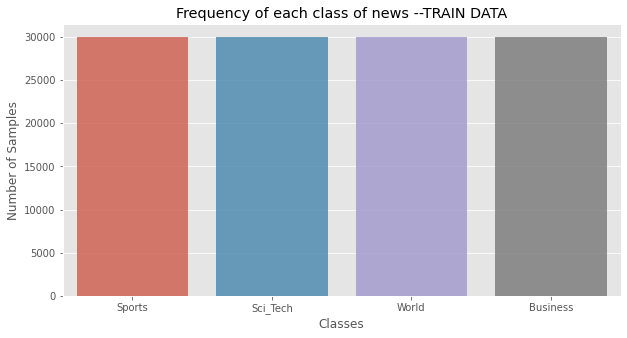

In [8]:
plt.style.use('ggplot')
classes  = train_data['Class'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(classes.index, classes.values, alpha=0.8)
plt.title('Frequency of each class of news --TRAIN DATA')
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


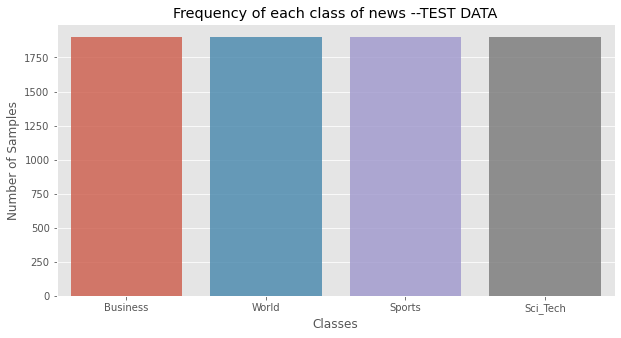

In [9]:
plt.style.use('ggplot')
classes  = test_data['Class'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(classes.index, classes.values, alpha=0.8)
plt.title('Frequency of each class of news --TEST DATA')
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.show()

# **4.Data Cleaning**

In [10]:
def data_cleaning (dataset,min_word_length = 3, max_seq_length = 100, normalise = True):
    
     
    """
    This funciton takes as input a dictionary containing the fields text & target. 
    The text in this dictonary is first preprocessed and then turned into tokens. 
    All words that are under min_word_length long are deleted
    before the datapoints are normalized (if norm == True) and then truncated to the max_seq_length
    and saved under "path".
    
    inputs:
    
        - dataset -> dict{'text', 'target'}
        - path -> String
        - max_seq_length -> int
        - norm -> bool
    
    """
    
    sep=' '
    df = pd.DataFrame(dataset)
    nans = 0
    lengths = 0
    print("Starting to preprocess the data.")
   
    for text_idx in tqdm_notebook(range(len(dataset['text']))):
       
        #print("before: ",dataset['text'][text_idx])
        
        #Replace '\n' with ' ' and remove noise from text   
        dataset['text'][text_idx] = dataset['text'][text_idx].replace("\n", " ")
        dataset['text'][text_idx] = noise_removal(dataset['text'][text_idx])    

        #Get list of words in the text
        word_list = dataset['text'][text_idx].split()       

        #Normalise the data    
        if normalise:
            try:
                word_list = normalize(word_list)
            except:
                pass

        #if len(word_list)<=min_word_length:
        #    word_list= ["<nan>"]
        #    nans +=1
        
        
        #if len(word_list) > max_seq_length:
        #    word_list = word_list[:max_seq_length]
        #    lengths +=1
        
        #print(len(word_list))
        
        #Replace the dataset text with normalised text
        dataset['text'][text_idx] = sep.join(word_list)
        #print("after: ",dataset['text'][text_idx])
        
        
    print("Preprocessing Finished.")
    return dataset
  
    


In [11]:
pp_train_data=data_cleaning(train_data)

Starting to preprocess the data.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Preprocessing Finished.


In [12]:
pp_test_data=data_cleaning(test_data)

Starting to preprocess the data.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Preprocessing Finished.


# **5.Split dataset to train ,val and text dataset**

In [13]:
# split the data into train and test data
pp_train,pp_val = train_test_split(train_data,test_size=0.2, random_state=1)
pp_test =pp_test_data

# **6.Save Train ,Val and Test Data as csv**




In [14]:
    #Save data to CSV
    def date_to_csv(dataset,path):
      df = pd.DataFrame(dataset)
      df = df.reset_index()
      del df['index']
      df.to_csv(path, index=False)

In [15]:
date_to_csv(pp_train,'/content/drive/MyDrive/NLP_Practicals_XAI/our_kge_code/agnews/pp_train.csv')

In [16]:
date_to_csv(pp_val,'/content/drive/MyDrive/NLP_Practicals_XAI/our_kge_code/agnews/pp_val.csv')

In [17]:
date_to_csv(pp_test,'/content/drive/MyDrive/NLP_Practicals_XAI/our_kge_code/agnews/pp_test.csv')